# Train VAE on SSP data

The notebook demonstrates the process of training a Variational Autoencoder (VAE) on precipitation and sea-surface temperature data. The model  is trained on different Shared Socio-economic Pathways (SSPs) data of CMIP6. The key steps and components involved are outlined as follows:

1. The VAE model consists of four components: encoder, latent sampling, decoder, and a second decoder for prediction. Separate model instances are created for each component:
    * _Encoder_ : The encoder takes a sample `x` and returns the mean `z_mean` and logarithmic variance `z_log_var` of the latent variable `z`.
    * _Latent Sampling_ : The latent sampling takes `z_mean` and `z_log_var` as inputs and generates a random latent sample `z`.
    * _Decoder_ : The decoder reconstructs the input `x` by taking the latent sample `z` and producing the decoded output `y`. The decoding is done backward in time, maintaining the input order.
   * _Decoder for Prediction_ : The second decoder also takes the latent sample `z` but generates a forward-time prediction output.

2. The full model is created by combining the four components. Model weights and training metrics are saved in a log directory (`LOG_DIR`). If the initial epoch (`INITIAL_EPOCH`) is greater than zero, the training continues from the saved weights; otherwise, a new training session starts.

3. The data used in training includes different SSPs of CMIP data as well as the corresponding forcing data. CMIP data is loaded from netCDF files and grouped by model name and run. The forcing data is loaded forcing data from a CSV file. The dataset is split into training and validation sets.

4. During training, generators are prepared for training and validation on CMIP data. A beta scheduler is used to scale the KL loss during training. Callbacks are set up to save model weights and metrics.  These callbacks enable tracking the progress of the training and provide checkpoints for the model.

## Requirements

1. The notebook requires the VAE package to be installed, which is available at:

    https://github.com/andr-groth/VAE-project

2. Sample data used in the notebook is included in the `data/` folder. The data is in netCDF format and has been prepared with the help of the CDO scripts, which are available at:

    https://andr-groth.github.io/cdo-scripts

## Imports

In [1]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
import itertools
import os
import random
from datetime import datetime
from types import SimpleNamespace

import numpy as np
import pandas as pd
import tensorflow.keras as ks
import tensorflow.keras.backend as K
import yaml
from IPython.display import display
from matplotlib import pyplot as plt
from matplotlib import ticker
from pytz import timezone
from tqdm.keras import TqdmCallback

In [3]:
from tensorflow import get_logger
from tensorflow.compat.v1 import disable_eager_execution, disable_v2_behavior

get_logger().setLevel('ERROR')
disable_eager_execution()
disable_v2_behavior()

In [4]:
from VAE import generators, models
from VAE.callbacks import ModelCheckpoint
from VAE.utils import beta_schedulers, fileio

In [5]:
FIGWIDTH = 16
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline
plt.style.use('seaborn-notebook')
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['figure.dpi'] = 75
np.set_printoptions(formatter={'float_kind': lambda x: f'{x: .3f}'}, linewidth=120)

## Log directory

In the folder `LOG_DIR`, the model weights and training metrics are saved. The metrics can be monitored with Tensorboard.

In [6]:
INITIAL_EPOCH = 0
LOG_DIR = r'logs'

Setting `INITIAL_EPOCH` to a value greater than zero will continue the training in `LOG_DIR`. Otherwise, a new training is started in a new subfolder created in `LOG_DIR`.

In [7]:
INITIAL_EPOCH = 25
LOG_DIR = os.path.join(LOG_DIR, '2023-05-30T18.58')

In [8]:
if INITIAL_EPOCH == 0:
    tz = timezone('Europe/Berlin')
    log_dir = os.path.join(LOG_DIR, datetime.now(tz).strftime('%Y-%m-%dT%H.%M'))
    os.makedirs(log_dir)
    print('Start training in:', os.path.normpath(log_dir))
else:
    log_dir = LOG_DIR
    assert os.path.exists(log_dir), 'Path not found'
    print(f'Continue training from epoch {INITIAL_EPOCH} in:', os.path.normpath(log_dir))

Continue training from epoch 25 in: logs\2023-05-30T18.58


## Parameters

First we specify the parameters of the model and the training (`model`, `data`, ...).

In [9]:
if INITIAL_EPOCH == 0:
    epochs = 25  # epochs for training
    level_range = [20, 20]  # number of PCs that will be used
    input_shape = [12, sum(level_range)]
    prediction_shape = [12, sum(level_range)]
    ensemble_size = 29  # number of CMIP models
    repeat_samples = 5  # batch ensemble size
    forcing_input_length = 16  # number of past forcing values (in years)
    dtype = 'float32'

    params = {
        # params for encoder and decoder
        'model': {
            'activation': 'swish',
            'beta': 'beta',
            'cond_size': [12 + forcing_input_length, ensemble_size],
            'cond_units': [64, 24],
            'cond_activation': ['swish', 'linear'],
            'cond_ens_size': 6,
            'cond_use_scale': False,
            'delta': 1,
            'encoder_blocks': 2,
            'fc_units': 64,
            'fc_activation': 'tanh',
            'film_temporal': True,
            'filters': 64,
            'gamma': 5,
            'input_shape': input_shape,
            'latent_dim': 32,
            'learning_rate': 2e-3,
            'pooling': None,
            'prediction_shape': prediction_shape,
            'padding_blocks': 1,
            'repeat_samples': repeat_samples,
            'residual_units': 1,
            'set_size': 1,
            '__version__': models.__version__,
        },
        # specific params for prediction model
        'prediction': {},
        'data': {
            'filename': [
                'data/cmip6/ssp/pr/pcs/pcs*.nc',
                'data/cmip6/ssp/tos/pcs/pcs*.nc',
            ],
            'level_range': [[level] for level in level_range],
            'time_interval': ['2015-01-01', '2100-12-31'],
            'dtype': dtype
        },
        'forcing': {
            'filename': 'data/cmip6/ssp/forcings/SSP_CMIP6_world_C02.csv',
            'scale': 1e-5,
            'input_length': forcing_input_length,
        },
        'beta_scheduler': {
            'class_name': 'LogisticGrowth',
            'config': {
                'upper': 50,
                'midpoint': 5,
                'rate': 1,
                'dtype': dtype
            }
        },
        'fit_generator': {
            'input_length': input_shape[0],
            'prediction_length': prediction_shape[0],
            'batch_size': 128,
            'ensemble_size': ensemble_size,
            'ensemble_type': 'index',
            'repeat_samples': repeat_samples,
            'shuffle': True,
            'strides': 1,
            'tp_period': 12,
            'validation_split': 70,
            'random_seed': 2,
            'dtype': dtype,
            '__version__': generators.__version__,
        },
        'model_fit': {
            'epochs': epochs
        },
    }

    fn = os.path.join(log_dir, 'trainer_config.yaml')
    with open(fn, 'w') as f:
        yaml.dump(params, f)

    print('Write configuration to:', os.path.normpath(fn))

else:
    fn = os.path.join(log_dir, 'trainer_config.yaml')
    with open(fn, 'r') as f:
        params = yaml.load(f, Loader=yaml.FullLoader)

    print('Load configuration from:', os.path.normpath(fn))

    assert params['model'].get('__version__') == models.__version__, 'Model version mismatch'
    assert params['fit_generator'].get('__version__') == generators.__version__, 'Generator version mismatch'

    params['fit_generator']['initial_epoch'] = INITIAL_EPOCH

params = SimpleNamespace(**params)
# print('')
# print(yaml.dump(params.__dict__))

Load configuration from: logs\2023-05-30T18.58\trainer_config.yaml


## Model

The VAE model consists of four components: encoder, latent sampling, decoder, and a second decoder for prediction. Separate model instances are created for each component.

### Encoder

The encoder takes a sample `x` and returns `z_mean` and `z_log_var`:

In [10]:
encoder = models.Encoder(**params.model, name='encoder')

### Latent sampling

The latent sampling takes the two inputs `z_mean` and `z_log_var` and returns a set of `set_size=1` random latent sample `z`:

In [11]:
latent_sampling = models.LatentSampling(**params.model, name='latent')

### Decoder

The decoder, finally, takes a latent sample `z` and returns the decoded output `y` to reconstruct `x`. The decoding works backward in time and we set `output_reverse=True` so that the order of decoder output matches the input to the encoder.

In [12]:
decoder = models.Decoder(output_shape=params.model.get('input_shape'),
                         decoder_blocks=params.model.get('encoder_blocks'),
                         output_reverse=True,
                         **params.model,
                         name='decoder')

### Decoder for prediction

Like the decoder, the second decoder takes the same latent sample `z` and it's output will provide the prediction. In contrast to the `decoder`, we set `output_reverse=False` so that the output of `prediction` is forward in time.

In [13]:
prediction = models.Decoder(output_shape=params.model.get('prediction_shape'),
                            output_reverse=False,
                            **{
                                'decoder_blocks': params.model.get('encoder_blocks'),
                                **params.model,
                                **params.prediction
                            },
                            name='prediction')

### Full model

Now that we have the four components, we a ready to create the full model.

In [14]:
model = models.VAEp(encoder, decoder, latent_sampling, prediction, **params.model)

Let's plot the model

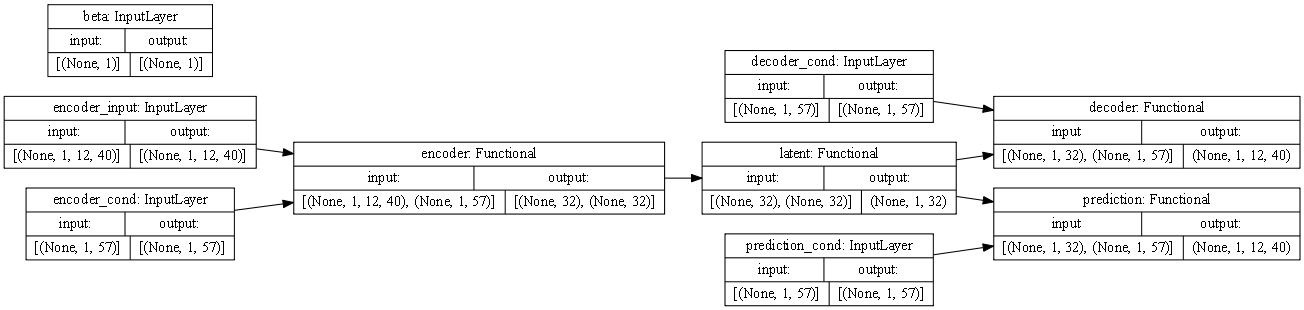

In [15]:
ks.utils.plot_model(model, show_shapes=True, dpi=75, rankdir='LR')

and summarizes the model

In [16]:
model.summary(line_length=120)

Model: "mVAEp"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
encoder_input (InputLayer)             [(None, 1, 12, 40)]        0                                                     
________________________________________________________________________________________________________________________
encoder_cond (InputLayer)              [(None, 1, 57)]            0                                                     
________________________________________________________________________________________________________________________
encoder (Functional)                   [(None, 32), (None, 32)]   185340        encoder_input[0][0]                     
                                                                                encoder_cond[0][0]                      
_________________

### Load model weights (optional)

Optionally, we load model weights if `INITIAL_EPOCH > 0` to continue the training.

In [17]:
if INITIAL_EPOCH > 0:
    model_file = os.path.join(log_dir, 'model.{epoch:02d}.h5'.format(epoch=INITIAL_EPOCH))
    model.load_weights(model_file, by_name=True)
    print('Load model weights from:', os.path.normpath(model_file))

Load model weights from: logs\2023-05-30T18.58\model.25.h5


## Data

In the following, we load the data. The data is prepared with the CDO scripts. They are available on Github: https://andr-groth.github.io/cdo-scripts.

We use CMIP6 data. The raw gridded data is prepared with the `prepare_data.sh` script. The script performs three main steps: creating anomalies, calculating ensemble EOFs, and obtaining individual PCs. The resulting data is stored in netCDF files and the folder is specified in `params.data['filename']`.

### CMIP data

We load the netCDF files of CMIP data.

In [18]:
_variables, _dimensions, _attributes = fileio.read_netcdf_multi(**params.data, num2date=True)

data\cmip6\ssp\pr\pcs\pcs*.nc  : 100 file(s) found.
data\cmip6\ssp\tos\pcs\pcs*.nc : 100 file(s) found.
200/200 [==============================] - 9s 47ms/file


We group the netCDF files and their variables by the global attributes `source_id` + `experiment_id`. The attribute `source_id` refers to the model name (e.g. `ACCESS-CM2`) and the attribute `experiment_id` to the experiment (e.g. `ssp126`).

In [19]:
variables = {}
dimensions = {}
attributes = {}

key1 = 'source_id'
key2 = 'experiment_id'
for key, values in _variables.items():
    target_key = (
        _attributes[key]['.'][key1],
        _attributes[key]['.'][key2],
    )

    variables.setdefault(target_key, {})
    dimensions.setdefault(target_key, {})
    attributes.setdefault(target_key, {})

    variables[target_key] |= {k: pd.DataFrame(v, index=_dimensions[key]['time']) for k, v in values.items()}
    dimensions[target_key] |= {k: _dimensions[key] for k in values.keys()}
    attributes[target_key] |= {k: _attributes[key] for k in values.keys()}

We make a few tests to check the integrity of the data.

In [20]:
variable_names = {tuple(val.keys()) for val in variables.values()}
if len(variable_names) > 1:
    raise ValueError(f'More than one variable combination found: {variable_names}')
else:
    variable_names, *_ = variable_names
    print('\N{check mark} One variable combination found:', variable_names)

variable_channels = {tuple(v.shape[-1] for v in val.values()) for val in variables.values()}
if len(variable_channels) > 1:
    raise ValueError(f'More than one channel combination found: {variable_channels}')
else:
    variable_channels, *_ = variable_channels
    print('\N{check mark} One channel combination found:', variable_channels)

✓ One variable combination found: ('pr', 'tos')
✓ One channel combination found: (20, 20)


The following table summarizes the models and their different runs.

In [21]:
print('Number of model runs found :', len(variables))
df = pd.crosstab(*list(zip(*list(variables.keys()))), rownames=[key1], colnames=[key2])
df.loc['--- Total ---'] = df.sum(axis=0)
display(df.replace(0, ''))

Number of model runs found : 100


experiment_id,ssp126,ssp245,ssp370,ssp585
source_id,,,,
ACCESS-CM2,1,1,1,1
ACCESS-ESM1-5,1,1,1,1
BCC-CSM2-MR,1,1,1,1
CAMS-CSM1-0,1,1,1,1
CAS-ESM2-0,1,1,1,1
CESM2-WACCM,1,1,1,1
CMCC-CM2-SR5,1,1,1,1
CMCC-ESM2,1,1,1,1
CanESM5,1,1,1,1


#### Plot data

In the following plot, we compare the different CMIP datasets.

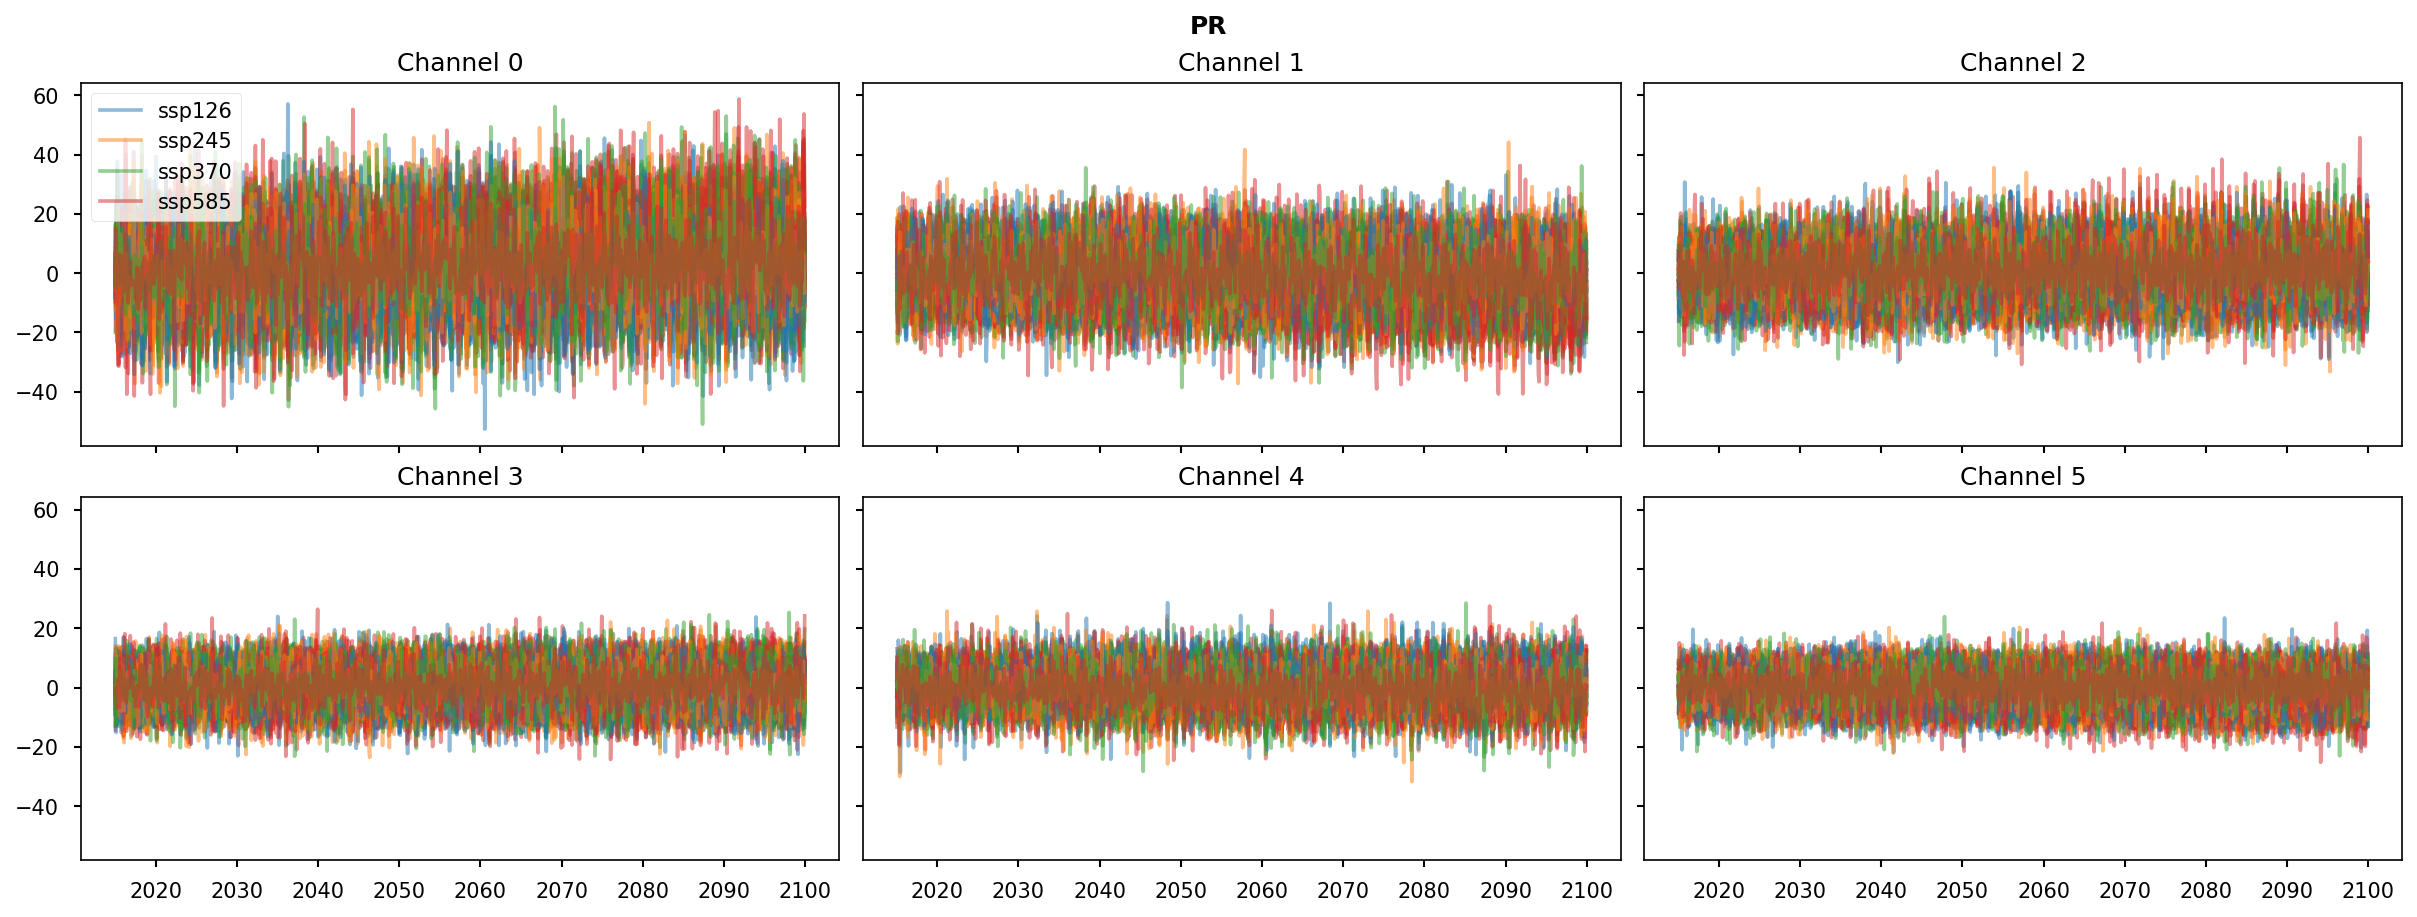

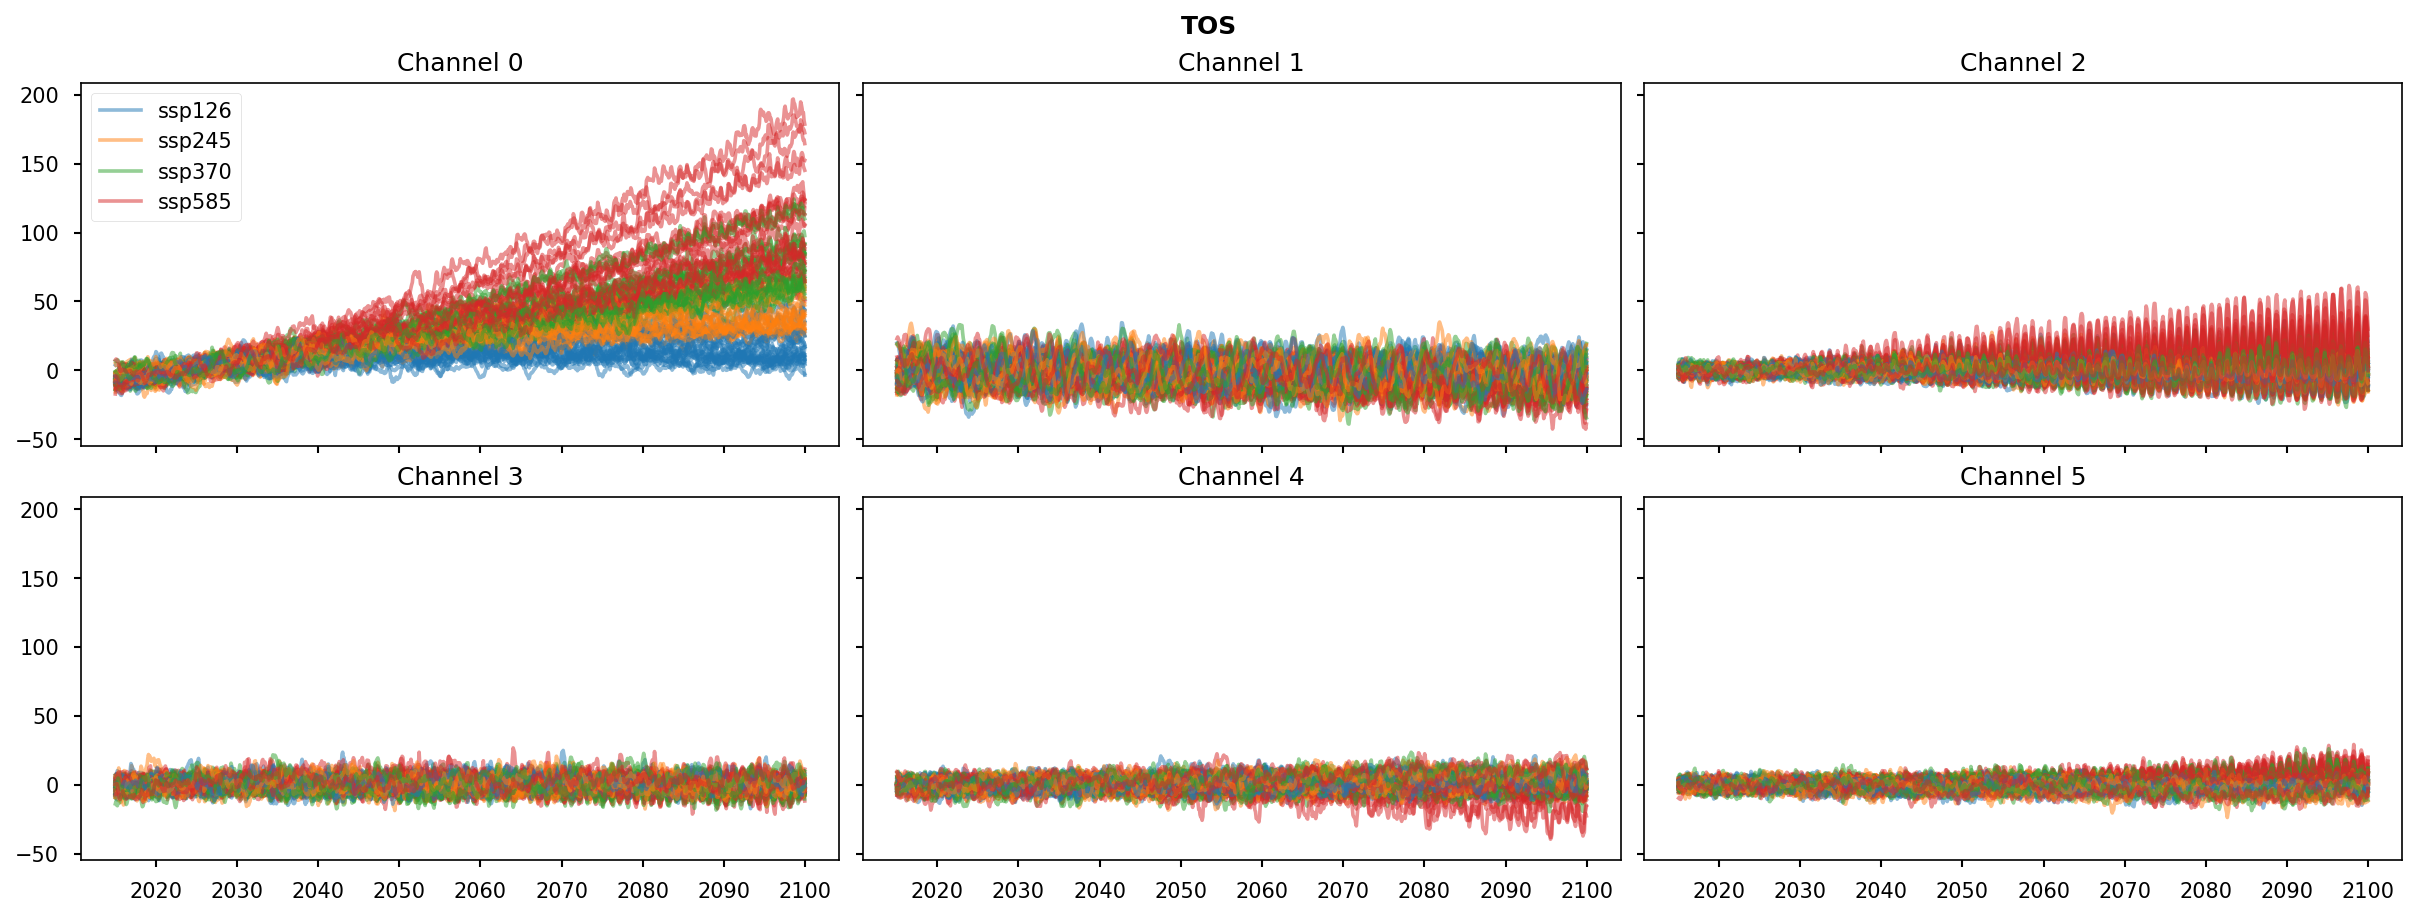

In [22]:
cols = 3
rows = 2

dataset_names = list(variables.keys())
_, first_idx, color_idx = np.unique([dataset_name[1] for dataset_name in dataset_names],
                                    return_index=True,
                                    return_inverse=True)

cm = plt.cm.get_cmap('tab10', 10)
color_dict = {name: cm(idx) for name, idx in zip(dataset_names, color_idx)}

for variable_name in variable_names:
    fig, axs = plt.subplots(rows, cols, sharex=True, sharey=True, figsize=(FIGWIDTH, 3 * rows), squeeze=False)
    fig.suptitle(variable_name.upper(), fontweight='bold')
    for idx, dataset_name in enumerate(dataset_names):
        for channel, (ax, values) in enumerate(zip(axs.flat, variables[dataset_name][variable_name].values.T)):
            label = dataset_name[1] if idx in first_idx else None
            ax.plot(variables[dataset_name][variable_name].index,
                    values,
                    color=color_dict[dataset_name],
                    label=label,
                    alpha=0.5)

            ax.set_title(f'Channel {channel}')

    axs.flat[0].legend()

We compare the variance of the different CMIP runs.

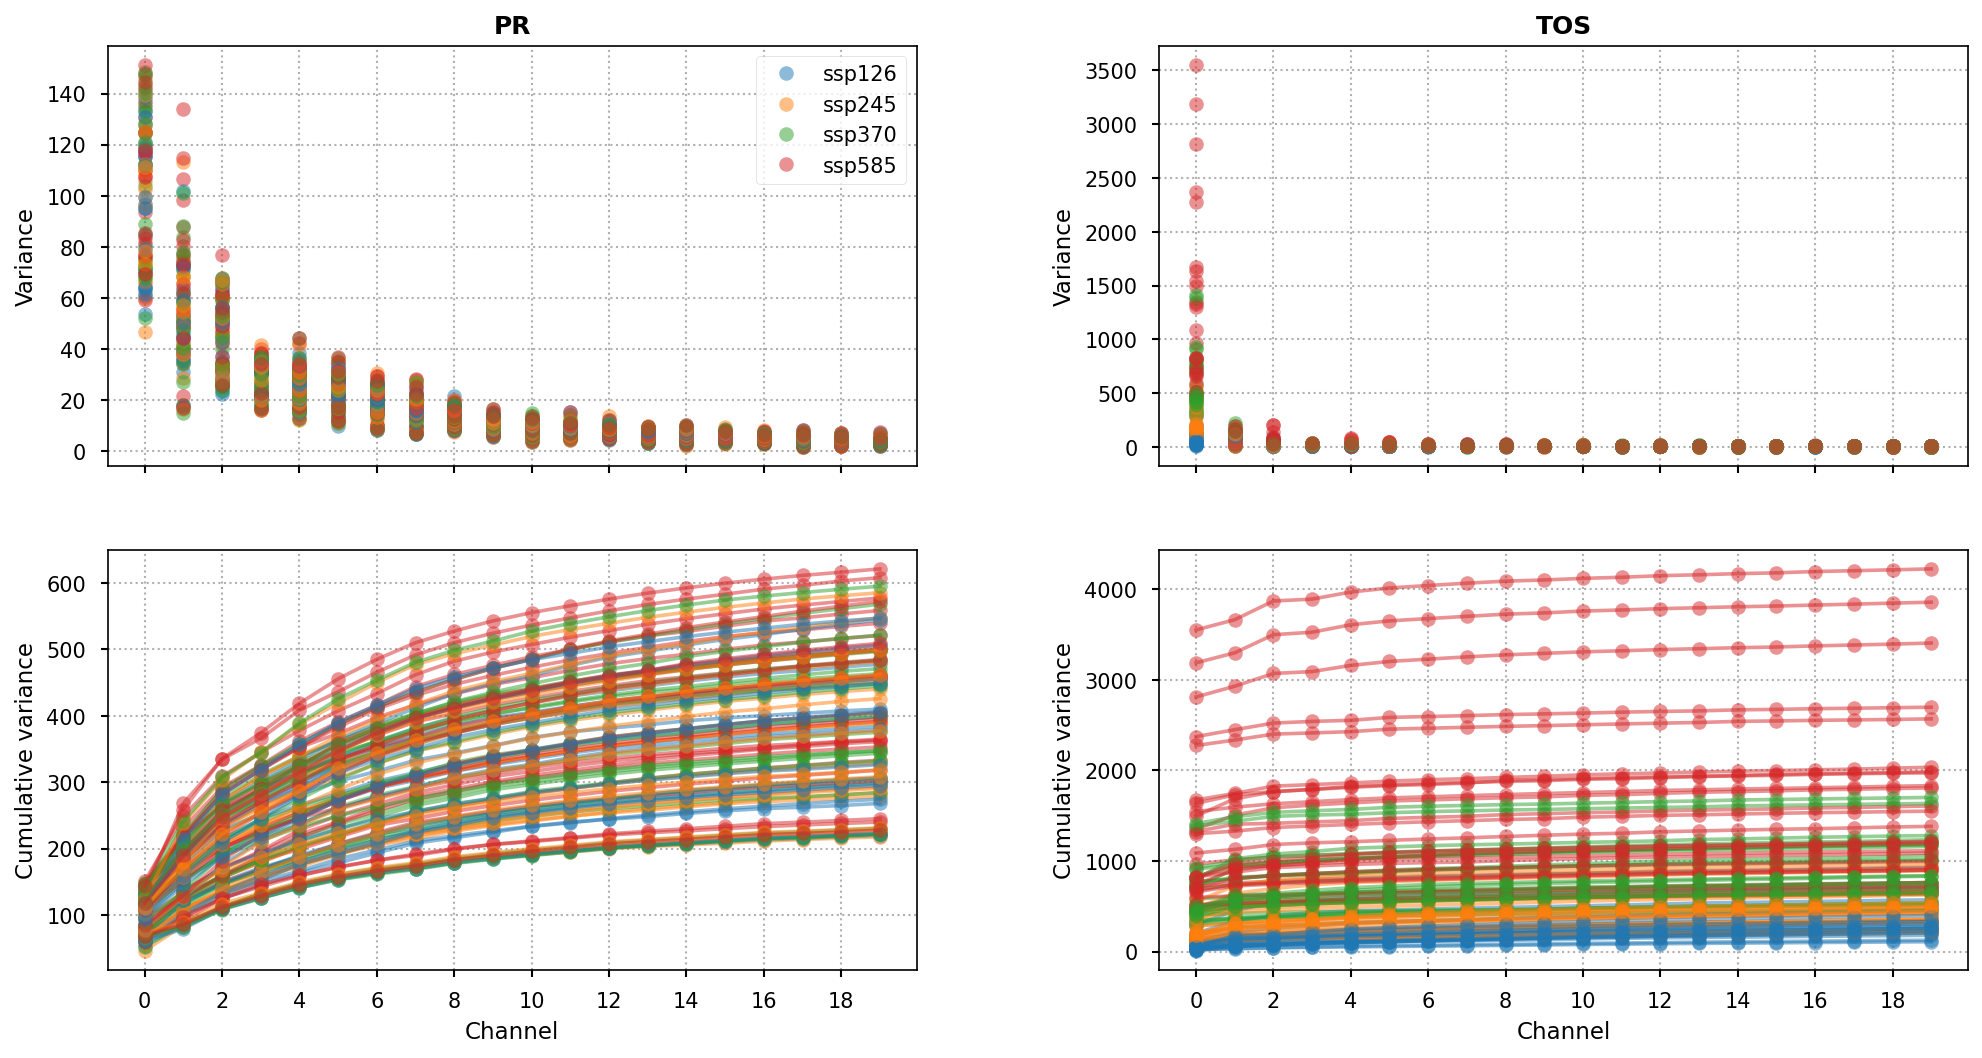

In [23]:
cols = len(variable_names)
fig, axs = plt.subplots(2, cols, figsize=(FIGWIDTH, 4 * cols), sharex=True, squeeze=False, gridspec_kw={'wspace': 0.3})
fig.subplots_adjust()

for (uax, bax), variable_name in zip(axs.T, variable_names):
    uax.set_title(variable_name.upper(), fontweight='bold')

    for idx, dataset_name in enumerate(dataset_names):
        data_var = variables[dataset_name][variable_name].var(axis=0)
        label = dataset_name[1] if idx in first_idx else None
        uax.plot(data_var, 'o', color=color_dict[dataset_name], label=label, alpha=0.5)

        data_cvar = np.cumsum(data_var, axis=0)
        bax.plot(data_cvar, '-o', color=color_dict[dataset_name], alpha=0.5)

    uax.set_ylabel('Variance')
    uax.grid(linestyle=':')

    bax.set_xlabel('Channel')
    bax.set_ylabel('Cumulative variance')
    bax.grid(linestyle=':')
    bax.xaxis.set_major_locator(ticker.MultipleLocator(2))

    axs.flat[0].legend()

#### Stack variables

For the training, we shuffle the datasets.

In [24]:
dataset_names_rand = list(variables.keys())
random.seed(params.fit_generator['random_seed'])
random.shuffle(dataset_names_rand)

The variables are stack along the last axis, the channels. We add a leading singleton dimension for `set_size=1`.

In [25]:
data_stack = [
    pd.concat([variables[dataset_name][variable_name] for variable_name in variable_names], axis=1, join='inner')
    for dataset_name in dataset_names_rand
]
time = [d.index for d in data_stack]
dataset = [d.to_numpy()[None, ...] for d in data_stack]

We split the datasets into one set for training and one set for validation.

In [26]:
validation_split = params.fit_generator['validation_split']
print('Size of training dataset   :', len(dataset[:validation_split]))
print('Size of validation dataset :', len(dataset[validation_split:]))

Size of training dataset   : 70
Size of validation dataset : 30


### Forcing data

We load the forcing data from a csv file. The first column is considered as the date and the remaining columns is the corresponding forcing data. The column header of the forcing data must match the `experiment_id`. The forcing data is interpolated to match the time scale of the CMIP data.

In [27]:
filename = params.forcing['filename']
forcing_df = pd.read_csv(filename, index_col=0, parse_dates=True)
print('Load forcing data from:', os.path.relpath(filename))

Load forcing data from: data\cmip6\ssp\forcings\SSP_CMIP6_world_C02.csv


In [28]:
forcing_df_daily = forcing_df.asfreq('D').interpolate(method='akima')

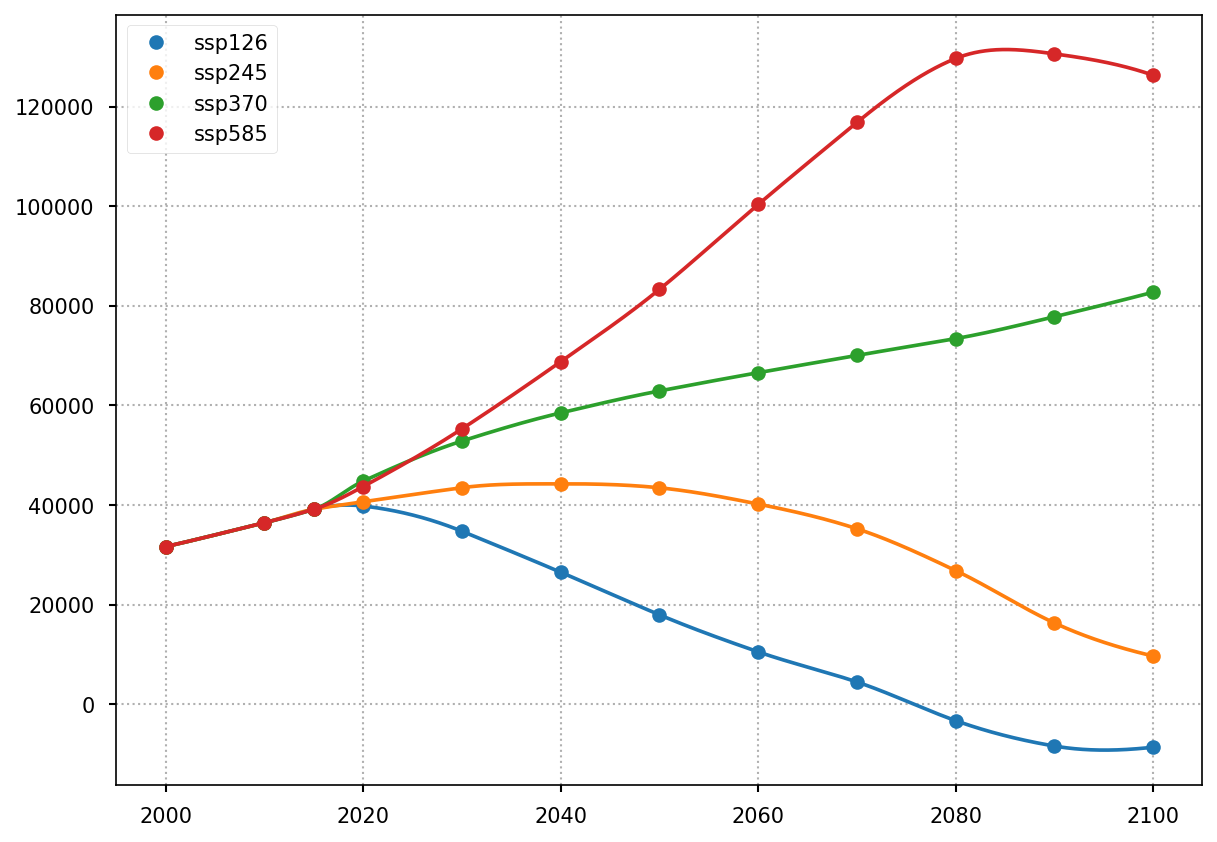

In [29]:
fig, ax = plt.subplots(1)
for n, (key, val) in enumerate(forcing_df.items()):
    ax.plot(val, 'o', color=cm(n), label=key)
    ax.plot(forcing_df_daily[key], '-', color=cm(n))

ax.legend()
ax.grid(linestyle=':')

Instead of providing only the current value of the forcing as condition, we can optionally provide past values as well. The parameter `input_length` in `params.forcing` determines the number of past values (in years) that will be provided as condition.

In [30]:
scale = params.forcing.get('scale', 1)
input_length = params.forcing.get('input_length', 1)

forcing_data = [
    np.stack([
        forcing_df_daily[experiment_id].reindex(t - pd.DateOffset(years=years), method='nearest').to_numpy() * scale
        for years in range(input_length)
    ],
             axis=1) for t, (_, experiment_id) in zip(time, dataset_names_rand)
]

## Model training

### Prepare generators

#### Beta scheduler

For the model training, we first need a scheduler for the beta values in each epoch that scales the KL loss. 

In [31]:
BetaScheduler = getattr(beta_schedulers, params.beta_scheduler.get('class_name'))
beta_scheduler = BetaScheduler(**params.beta_scheduler.get('config'))
beta_scheduler.summary()

Summary of "LogisticGrowth" (BetaScheduler)
  dtype    : float32
  lower    : 0.0
  upper    : 50
  midpoint : 5
  rate     : 1


#### Fit generator

A first generator takes the first set of the CMIP data. This generator is used to train the model.

In [32]:
month = [t.to_numpy().astype('datetime64[M]').astype(int) for t in time]
_, model_index = np.unique([dataset_name[0] for dataset_name in dataset_names_rand], return_inverse=True)
fit_gen = generators.FitGenerator(dataset[:validation_split],
                                  **params.fit_generator,
                                  beta_scheduler=beta_scheduler,
                                  time=month[:validation_split],
                                  ensemble_index=model_index[:validation_split],
                                  condition=forcing_data[:validation_split])
fit_gen.summary()

Number of datasets : 70
Total data size    : 2,855,520
Total data length  : 71,388
Strides            : 1
Number of samples  : 69,778
Batch size         : 128
Number of batches  : 546
Sample repetitions : 5
Actual batch size  : 128 * 5 = 640
Shuffle            : True
Ensemble condition
  size : 29
  type : index
Input channels     : all
Predicted channels : all
Output shapes
  inputs
    encoder_input    : (640, 1, 12, 40)
    encoder_cond     : (640, 1, 57)
    decoder_cond     : (640, 1, 57)
    prediction_cond  : (640, 1, 57)
    beta             : (640, 1)
  targets
    decoder          : (640, 1, 12, 40)
    prediction       : (640, 1, 12, 40)


#### Validation generator

A second generator takes the second set of CMIP data. The generator is used to evaluate the sucess of the training to generalize to independent CMIP runs.

In [33]:
if dataset[validation_split:]:
    val_gen = generators.FitGenerator(dataset[validation_split:],
                                      **params.fit_generator,
                                      beta_scheduler=beta_scheduler,
                                      time=month[validation_split:],
                                      ensemble_index=model_index[validation_split:],
                                      condition=forcing_data[validation_split:])
    val_gen.summary()
else:
    val_gen = None
    print('No validation data.')

Number of datasets : 30
Total data size    : 1,224,000
Total data length  : 30,600
Strides            : 1
Number of samples  : 29,910
Batch size         : 128
Number of batches  : 234
Sample repetitions : 5
Actual batch size  : 128 * 5 = 640
Shuffle            : True
Ensemble condition
  size : 29
  type : index
Input channels     : all
Predicted channels : all
Output shapes
  inputs
    encoder_input    : (640, 1, 12, 40)
    encoder_cond     : (640, 1, 57)
    decoder_cond     : (640, 1, 57)
    prediction_cond  : (640, 1, 57)
    beta             : (640, 1)
  targets
    decoder          : (640, 1, 12, 40)
    prediction       : (640, 1, 12, 40)


### Prepare callbacks

The callbacks are used to save the model weights and evaluation metrics in the `LOG_DIR`. The progress of the training can be monitored with Tensorboard.

In [34]:
callbacks = [
    ModelCheckpoint(filepath=os.path.join(log_dir, 'model.{epoch:02d}.h5'),
                    period=5,
                    save_best_only=False,
                    save_weights_only=True),
    ks.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=False),
]

### Fit model

Finally, we start the training of the model.

In [35]:
hist = model.fit(fit_gen,
                 validation_data=val_gen,
                 initial_epoch=INITIAL_EPOCH,
                 **params.model_fit,
                 callbacks=callbacks + [TqdmCallback(verbose=1)],
                 verbose=0)

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]